# Regression Models

Here, we explore different regression models to predict the number of followers (log-scale) of each playlist. We use 2 sets of features and fitted 2 sets of regression models respectively.

- Feature set 1: **main predictors only**
- Feature set 2: **main predictors and interaction terms of (genre X numerical_audio_feature_avg)**

For each set of features, do the following 2 steps:
- Use main predictors only and fit **single** regression models:
    - Linear Regression
    - (Perform PCA on the main predictors and interaction terms set of features)
    - RidgeCV
    - LassoCV
    - Random Forest Regressor
    - Adaboost Regressor

- **Stack** all fitted models on the training set together to fit a
    - **Meta regressor 1: Weighted Average ** 
        - Gather the predicted values of all the fitted single models on the validation set
        - Average each single model's predicted value weighted by its accuracy on the same validation set
    
    - **Meta regressor 2: Meta Linear Regressor ** 
        - Gather the predicted values of all the fitted single models on the validation set
        - Fit a linear regression model on these single models' predicted values

As shown in the **summary** part at the end of this notebook, **Random Forest Regressor is the best single model** and the stacked **Meta Linear Regression model is overall the best**. Comparing models with the 2 sets of features, both have overall comparable test accuracies. The interaction terms between genre and avg of numerical audio features slightly improved test accuracies for the **RidgeCV, LassoCV and weighted average meta model** but not for the other models. This suggests that some of the interaction terms are useful while others are not. Thus, the models fitted on main predictors and interaction terms are (to some extent) overfitted.

In [1]:
# import libraries
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Image
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.externals import joblib
from itertools import product
from collections import OrderedDict
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Save scraped data to json file
def dump_data(data_to_json, file):
    # example: file = '../data/playlists_5088.json'
    with open(file,'w') as fd:
        json.dump(data_to_json, fd)

# Load json file
def load_data(file):
    with open(file, 'r') as fd:
        data_from_json = json.load(fd)
        return data_from_json

## Regression models with main predictors only

### Data Processing

Take **log transform** of the skewed response variable:

**`num_followers` -> `log_num_followers`**

In [3]:
# Read dataframe
playlists_df_full = pd.read_csv('../../data/playlists.csv')
playlists_df_full.head()

,collaborative,num_followers,num_tracks,track_acousticness_avg,track_acousticness_std,track_album_popularity_avg,track_album_popularity_max,track_album_popularity_std,track_artists_genres_unique,track_avg_artist_num_followers_avg,...,track_std_artist_num_followers_std,track_std_artist_popularity_avg,track_std_artist_popularity_std,track_tempo_avg,track_tempo_std,track_time_signature_mode,track_time_signature_unique,track_valence_avg,track_valence_std,genre
0,False,3000606,52,0.180999,0.171120,71.673077,96,13.136445,60,1.276693e+06,...,9.211661e+05,1.784248,3.081549,116.689288,25.194937,4,1,0.456071,0.184214,pop
1,False,69037,75,0.144201,0.160799,68.440000,100,15.511063,70,3.791621e+06,...,1.539587e+06,2.114856,3.171820,114.453907,24.115022,4,2,0.555027,0.191440,pop
2,False,385875,38,0.116600,0.117615,72.421053,94,16.192317,44,2.319518e+06,...,2.050419e+06,2.126763,2.151793,115.812500,22.759341,4,1,0.526526,0.201783,pop
3,False,69344,40,0.134162,0.247197,57.025000,82,18.083815,97,2.387520e+06,...,3.080303e+05,0.037500,0.172753,126.490950,29.521523,4,2,0.501825,0.188804,pop
4,False,15612,26,0.171635,0.229736,53.461538,54,0.498519,5,8.566853e+04,...,1.278704e+04,3.346290,3.184129,126.677692,33.241999,4,1,0.658846,0.184523,pop


In [4]:
# Log transformation
playlists_df_full['log_num_followers'] = np.log(list(playlists_df_full['num_followers']+1))

# Dropping the original num_followers, num_tracks
playlists_df_full.drop(['num_followers'], axis=1, inplace=True)

Take **one-hot** encoding of the categorical variables

In [5]:
# Drop the useless varaible 'collaborative'
playlists_df_full.drop(['collaborative'], axis=1, inplace=True)
categorical_predictors = ['genre', 'track_time_signature_mode', 'track_key_mode']
numerical_predictors = list(set(playlists_df_full.columns.values) - set(categorical_predictors))

# One-hot encode categorical features
playlists_df_full = pd.get_dummies(playlists_df_full, prefix = categorical_predictors, 
                                         columns = categorical_predictors, drop_first = True)

In [6]:
def change_column_order(df, col_name, index): 
    """
    Function to change column order in a dataframe
    """
    cols = df.columns.tolist() 
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

# Reorder so that the response variable is the last column
playlists_df_full = change_column_order(playlists_df_full, 'log_num_followers', len(playlists_df_full.columns))

playlists_df_full.head()

,num_tracks,track_acousticness_avg,track_acousticness_std,track_album_popularity_avg,track_album_popularity_max,track_album_popularity_std,track_artists_genres_unique,track_avg_artist_num_followers_avg,track_avg_artist_num_followers_std,track_avg_artist_popularity_avg,...,track_key_mode_3,track_key_mode_4,track_key_mode_5,track_key_mode_6,track_key_mode_7,track_key_mode_8,track_key_mode_9,track_key_mode_10,track_key_mode_11,log_num_followers
0,52,0.180999,0.171120,71.673077,96,13.136445,60,1.276693e+06,1.320843e+06,82.256410,...,0,0,0,0,0,0,0,0,1,14.914325
1,75,0.144201,0.160799,68.440000,100,15.511063,70,3.791621e+06,3.658858e+06,84.684000,...,0,0,0,0,0,0,0,0,0,11.142412
2,38,0.116600,0.117615,72.421053,94,16.192317,44,2.319518e+06,2.237652e+06,86.705263,...,0,0,0,0,0,0,0,0,1,12.863271
3,40,0.134162,0.247197,57.025000,82,18.083815,97,2.387520e+06,3.589807e+06,72.987500,...,0,0,0,1,0,0,0,0,0,11.146849
4,26,0.171635,0.229736,53.461538,54,0.498519,5,8.566853e+04,2.347853e+05,55.059341,...,0,0,0,0,0,0,1,0,0,9.655859


In [7]:
print('Is there any missing values in our data: {}'.format(playlists_df_full.isnull().values.any()))

Is there any missing values in our data: False


Split data **6:1:1**
1. **train set** for single models: 6/8 of all data
2. **validation set** for single models & **train set for meta models**: 1/8 of all data
3. **test set**: 1/8 of all data

In [8]:
np.random.seed(9001)
msk1 = np.random.rand(len(playlists_df_full)) < 0.75
playlists_df_train_main = playlists_df_full[msk1]
playlists_df_nontrain_main = playlists_df_full[~msk1]

msk12 = np.random.rand(len(playlists_df_nontrain_main)) < 0.5
playlists_df_valid_main = playlists_df_nontrain_main[msk12]
playlists_df_test_main = playlists_df_nontrain_main[~msk12]

In [9]:
# Build predictors & response
X_train_main = playlists_df_train_main.iloc[:,:-1]
X_valid_main = playlists_df_valid_main.iloc[:,:-1]
X_test_main = playlists_df_test_main.iloc[:,:-1]

y_train = playlists_df_train_main['log_num_followers']
y_valid = playlists_df_valid_main['log_num_followers']
y_test = playlists_df_test_main['log_num_followers']

X_train_main.shape, y_train.shape, X_valid_main.shape, y_valid.shape, X_test_main.shape, y_test.shape

((7083, 85), (7083,), (1214, 85), (1214,), (1133, 85), (1133,))

Drop columns that have only 0, and **standardize** numerical variables using **train set's mean and std**

In [10]:
for col in X_train_main.columns:
    if (X_train_main[col] == 0).all():
        X_train_main.drop(col, axis=1, inplace=True)
    else:
        # Standardize a numerical variable
        if not np.logical_or((X_train_main[col]==0), ((X_train_main[col]==1))).all():
            mean_train = X_train_main[col].mean()
            std_train = X_train_main[col].std()
            X_train_main[col] = (X_train_main[col] - mean_train) / std_train
            X_valid_main[col] = (X_valid_main[col] - mean_train) / std_train
            X_test_main[col] = (X_test_main[col] - mean_train) / std_train


### Regression Models

#### Linear regression

In [11]:
# Fit & Save model
sim_lin_main = LinearRegression().fit(X_train_main, y_train)
joblib.dump(sim_lin_main, '../../fitted_models/sim_lin_main.pkl') 

In [12]:
# Load fitted model to reproduce results
sim_lin_main = joblib.load('../../fitted_models/sim_lin_main.pkl') 
print('-- Linear Regression with all main predictors only --')
print('Training R^2: ', sim_lin_main.score(X_train_main, y_train))
print('Test R^2: ', sim_lin_main.score(X_test_main, y_test))

-- Linear Regression with all main predictors only --
Training R^2:  0.263847739771
Test R^2:  0.252153441084


#### RidgeCV

In [13]:
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
ridge_cv_main = RidgeCV(alphas=lambdas, fit_intercept=True).fit(X_train_main, y_train)
joblib.dump(ridge_cv_main, '../../fitted_models/ridge_cv_main.pkl') 

In [14]:
# Load fitted model
ridge_cv_main = joblib.load('../../fitted_models/ridge_cv_main.pkl') 
ridge_r2_train_main = ridge_cv_main.score(X_train_main, y_train)
ridge_r2_test_main = ridge_cv_main.score(X_test_main, y_test)

print('-- RidgeCV (best alpha = {}) with all main predictors only --'.format(ridge_cv_main.alpha_))
print("Training R^2: {}".format(ridge_r2_train_main))
print("Test R^2: {}".format(ridge_r2_test_main))

-- RidgeCV (best alpha = 10.0) with all main predictors only --
Training R^2: 0.263451109837063
Test R^2: 0.25052396982949465


#### LassoCV

In [15]:
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
lasso_cv_main = LassoCV(alphas=lambdas, fit_intercept=True).fit(X_train_main, y_train)
joblib.dump(lasso_cv_main, '../../fitted_models/lasso_cv_main.pkl') 

In [16]:
# Load fitted model
lasso_cv_main = joblib.load('../../fitted_models/lasso_cv_main.pkl') 
lasso_r2_train_main = lasso_cv_main.score(X_train_main, y_train)
lasso_r2_test_main = lasso_cv_main.score(X_test_main, y_test)

print('-- LassoCV (best alpha = {}) with all main predictors only --'.format(lasso_cv_main.alpha_))
print("Training R^2: {}".format(lasso_r2_train_main))
print("Test R^2: {}".format(lasso_r2_test_main))

-- LassoCV (best alpha = 0.01) with all main predictors only --
Training R^2: 0.2556596987903933
Test R^2: 0.24914685865189712


#### Random Forest

In [17]:
RF_params = OrderedDict(
    n_estimators = [2**(i+2) for i in np.arange(7)],
    max_features = [0.1, 0.3, 0.5, 0.7, 0.9]
)
RF_params.values()

odict_values([[4, 8, 16, 32, 64, 128, 256], [0.1, 0.3, 0.5, 0.7, 0.9]])

In [18]:
# Use 5-fold validation to find the optimal n_estimators and max_features for Random Forest Regression
cv_scores_RF_main = []
params_dict_RF_main = {}

for i, (n, f) in enumerate(product(*RF_params.values())):
    params_dict_RF_main[i] = (n, f)
    
    # Cross Validation on Random Forest Classifier
    RF_main = RandomForestRegressor(oob_score=False, n_estimators=n, max_features=f, n_jobs=-1, random_state=22)
    scores = cross_val_score(RF_main, X_train_main, y_train, cv=5, scoring='r2')
    cv_scores_RF_main.append(scores.mean())

# Get the optimal set of parameters of the Random Forest Regressor
idx_optimal = np.argmax(cv_scores_RF_main)
optimal_params_RF_main = params_dict_RF_main[idx_optimal]
print('-- Random Forest Regression --')
print('Maximum R^2 validation score = {}'.format(max(cv_scores_RF_main)))
print('Optimal n_estimators = {}'.format(optimal_params_RF_main[0]))
print('Optimal max_features = {}'.format(optimal_params_RF_main[1]))

# Fit the optimal RF
RF_best_main = RandomForestRegressor(oob_score=False, n_estimators=optimal_params_RF_main[0], 
                                     max_features=optimal_params_RF_main[1], n_jobs=-1, 
                                     random_state=22).fit(X_train_main, y_train)
RF_best_r2_train_main = RF_best_main.score(X_train_main, y_train)
RF_best_r2_test_main = RF_best_main.score(X_test_main, y_test)
print('-- Best Random Forest Regression --')
print("Training R^2: {}".format(RF_best_r2_train_main))
print("Test R^2: {}".format(RF_best_r2_test_main))

# Dump fitted model to disk
joblib.dump(RF_best_main, '../../fitted_models/RF_best_main.pkl') 

Load fitted model to reproduce results directly

In [19]:
# Load fitted model to reproduce results
RF_best_main = joblib.load('../../fitted_models/RF_best_main.pkl') 
RF_best_r2_train_main = RF_best_main.score(X_train_main, y_train)
RF_best_r2_test_main = RF_best_main.score(X_test_main, y_test)
print('-- Best Random Forest Regression with all main predictors only --')
print("Training R^2: {}".format(RF_best_r2_train_main))
print("Test R^2: {}".format(RF_best_r2_test_main))

-- Best Random Forest Regression with all main predictors only --
Training R^2: 0.9263072080770891
Test R^2: 0.48156931235472966


#### Adaboost 

In [20]:
ab_params = OrderedDict(
    base_depths = [2, 4, 6, 8],
    n_estimators = [2**(i+2) for i in np.arange(7)]
)
ab_params.values()

odict_values([[2, 4, 6, 8], [4, 8, 16, 32, 64, 128, 256]])

In [21]:
# Use 5-fold CV to choose max_depth & n_estimators in AdaBoost Regressor
l_rate = 0.05
params_dict_ab_main = {}
cv_scores_ab_main = []
for i, (d, n) in enumerate(product(*ab_params.values())):
    params_dict_ab_main[i] = (d, n)
    ab_main = AdaBoostRegressor(DecisionTreeRegressor(max_depth=d, random_state=22), n_estimators=n, 
                                learning_rate=l_rate, random_state=22)
    scores = cross_val_score(ab_main, X_train_main, y_train, cv=5, scoring='r2')
    cv_scores_ab_main.append(scores.mean())


# Get the optimal set of parameters of the Random Forest Regressor
idx_optimal = np.argmax(cv_scores_ab_main)
optimal_params_ab_main = params_dict_ab_main[idx_optimal]
print('-- AdaBoost Regression --')
print('Maximum R^2 cv score = {}'.format(max(cv_scores_ab_main)))
print('Optimal base tree max_depth = {}'.format(optimal_params_ab_main[0]))
print('Optimal n_estimators = {}'.format(optimal_params_ab_main[1]))


# Fit the best Adaboost Regressor
ab_best_main = AdaBoostRegressor(DecisionTreeRegressor(max_depth=optimal_params_ab_main[0], random_state=22), 
                                 n_estimators=optimal_params_ab_main[1], learning_rate=l_rate, 
                                 random_state=22).fit(X_train_main, y_train)
ab_best_r2_train_main = ab_best_main.score(X_train_main, y_train)
ab_best_r2_test_main = ab_best_main.score(X_test_main, y_test)
print('-- Best AdaBoost Regression --')
print("Training R^2: {}".format(ab_best_r2_train_main))
print("Test R^2: {}".format(ab_best_r2_test_main))

# Dump fitted model to disk
joblib.dump(ab_best_main, '../../fitted_models/ab_best_main.pkl') 

Load fitted model to reproduce results directly

In [22]:
# Load fitted model to reproduce results
ab_best_main = joblib.load('../../fitted_models/ab_best_main.pkl') 
ab_best_r2_train_main = ab_best_main.score(X_train_main, y_train)
ab_best_r2_test_main = ab_best_main.score(X_test_main, y_test)
print('-- Best AdaBoost Regression --')
print("Training R^2: {}".format(ab_best_r2_train_main))
print("Test R^2: {}".format(ab_best_r2_test_main))

-- Best AdaBoost Regression --
Training R^2: 0.6574644836867659
Test R^2: 0.4194601631510584


#### Meta Model: Weighted Avg

In [23]:
prefix = '../../fitted_models/'
suffix = '.pkl'
models_main = ['sim_lin_main', 'ridge_cv_main', 'lasso_cv_main', 'RF_best_main', 'ab_best_main']

# Record model's r2 score and predicted results on validation set
weights_main = np.zeros((len(models_main),))
preds_main_valid = np.zeros((y_valid.shape[0], len(models_main)))
preds_main_test = np.zeros((y_test.shape[0], len(models_main)))
for i, name in enumerate(models_main):
    model_name = prefix + name + suffix
    model = joblib.load(model_name) 
    weights_main[i] = model.score(X_valid_main, y_valid)
    preds_main_valid[:, i] = model.predict(X_valid_main)
    preds_main_test[:, i] = model.predict(X_test_main)

weights_main = weights_main/np.sum(weights_main)
meta_pred_main_valid = np.average(preds_main_valid, axis=1, weights=weights_main)
meta_pred_main_test = np.average(preds_main_test, axis=1, weights=weights_main)

# Print model performance
meta_r2_valid_main = r2_score(y_valid, meta_pred_main_valid)
meta_r2_test_main = r2_score(y_test, meta_pred_main_test)
print('-- Meta model 1: Weighted Avg with main predictors only --')
print("Valid R^2: {}".format(meta_r2_valid_main))
print("Test R^2: {}".format(meta_r2_test_main))

-- Meta model 1: Weighted Avg with main predictors only --
Valid R^2: 0.4051594155555923
Test R^2: 0.41065615616702467


#### Meta Model: Linear Regression

In [24]:
# Record model's predicted results on validation set as the train set for the meta regressor
meta_X_train_main = np.zeros((y_valid.shape[0], len(models_main)))
meta_X_test_main = np.zeros((y_test.shape[0], len(models_main)))
for i, name in enumerate(models_main):
    model_name = prefix + name + suffix
    model = joblib.load(model_name) 
    meta_X_train_main[:, i] = model.predict(X_valid_main)
    meta_X_test_main[:, i] = model.predict(X_test_main)

meta_reg_main = LinearRegression().fit(meta_X_train_main, y_valid)
joblib.dump(meta_reg_main, '../../fitted_models/meta_reg_main.pkl') # Dump fitted model to disk

# Load fitted model to reproduce results
meta_reg_main = joblib.load('../../fitted_models/meta_reg_main.pkl') 
print('-- Meta model 2: Linear Regression with main predictors only --')
print("Train R^2: {}".format(meta_reg_main.score(meta_X_train_main, y_valid)))
print("Test R^2: {}".format(meta_reg_main.score(meta_X_test_main, y_test)))

-- Meta model 2: Linear Regression with main predictors only --
Train R^2: 0.48592344342771787
Test R^2: 0.4965343020024535


## Regression models on main predictors & interaction terms

### Data Processing

Add interaction terms between **genres** and the **numerical audio features' average**

In [25]:
audio_features_avg = ['track_acousticness_avg', 'track_album_popularity_avg', 'track_danceability_avg',
                    'track_duration_ms_avg', 'track_energy_avg', 'track_explicit_avg', 
                    'track_instrumentalness_avg', 'track_liveness_avg', 'track_loudness_avg', 'track_mode_avg', 
                    'track_speechiness_avg', 'track_tempo_avg', 'track_valence_avg']
genres = ['genre_blues', 'genre_classical', 'genre_country', 'genre_dance',
       'genre_edm', 'genre_elect', 'genre_folk', 'genre_funk', 'genre_hip hop',
       'genre_house', 'genre_indie', 'genre_indie pop', 'genre_jazz',
       'genre_korean pop', 'genre_mellow', 'genre_metal', 'genre_other',
       'genre_pop', 'genre_pop christmas', 'genre_pop rap', 'genre_punk',
       'genre_r&b', 'genre_rap', 'genre_reggae', 'genre_rock', 'genre_soul',]

cross_terms = audio_features_avg + genres

In [26]:
# Make a copy of the original playlists dataframe
playlists_df_interaction = deepcopy(playlists_df_full)

# Generate 2-way interaction terms
for feature in audio_features_avg:
    for genre in genres:
        playlists_df_interaction[feature+'_X_'+genre] = playlists_df_full[feature] * playlists_df_full[genre]

playlists_df_interaction = change_column_order(playlists_df_interaction, 'log_num_followers', len(playlists_df_interaction.columns))
playlists_df_interaction.head()

,num_tracks,track_acousticness_avg,track_acousticness_std,track_album_popularity_avg,track_album_popularity_max,track_album_popularity_std,track_artists_genres_unique,track_avg_artist_num_followers_avg,track_avg_artist_num_followers_std,track_avg_artist_popularity_avg,...,track_valence_avg_X_genre_pop,track_valence_avg_X_genre_pop christmas,track_valence_avg_X_genre_pop rap,track_valence_avg_X_genre_punk,track_valence_avg_X_genre_r&b,track_valence_avg_X_genre_rap,track_valence_avg_X_genre_reggae,track_valence_avg_X_genre_rock,track_valence_avg_X_genre_soul,log_num_followers
0,52,0.180999,0.171120,71.673077,96,13.136445,60,1.276693e+06,1.320843e+06,82.256410,...,0.456071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.914325
1,75,0.144201,0.160799,68.440000,100,15.511063,70,3.791621e+06,3.658858e+06,84.684000,...,0.555027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.142412
2,38,0.116600,0.117615,72.421053,94,16.192317,44,2.319518e+06,2.237652e+06,86.705263,...,0.526526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.863271
3,40,0.134162,0.247197,57.025000,82,18.083815,97,2.387520e+06,3.589807e+06,72.987500,...,0.501825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.146849
4,26,0.171635,0.229736,53.461538,54,0.498519,5,8.566853e+04,2.347853e+05,55.059341,...,0.658846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.655859


Split data **6:1:1**
1. **train set** for single models: 6/8 of all data
2. **validation set** for single models & **train set for meta models**: 1/8 of all data
3. **test set**: 1/8 of all data

In [27]:
# Split data into train & test set
np.random.seed(9001)
msk2 = np.random.rand(len(playlists_df_interaction)) < 0.75
playlists_df_train_int = playlists_df_interaction[msk2]
playlists_df_nontrain_int = playlists_df_interaction[~msk2]

msk22 = np.random.rand(len(playlists_df_nontrain_int)) < 0.5
playlists_df_valid_int = playlists_df_nontrain_int[msk22]
playlists_df_test_int = playlists_df_nontrain_int[~msk22]

In [28]:
# Build predictors & response
X_train_int = playlists_df_train_int.iloc[:,:-1]
X_valid_int = playlists_df_valid_int.iloc[:,:-1]
X_test_int = playlists_df_test_int.iloc[:,:-1]

X_train_int.shape, y_train.shape, X_valid_int.shape, y_valid.shape, X_test_int.shape, y_test.shape

((7083, 423), (7083,), (1214, 423), (1214,), (1133, 423), (1133,))

Drop columns that have only 0 and **standardize** numerical variables using **train set's mean and std**

In [29]:
for col in X_train_int.columns:
    if (X_train_int[col] == 0).all():
        X_train_int.drop(col, axis=1, inplace=True)
    else:
        # Standardize a numerical variable
        if not np.logical_or((X_train_int[col]==0), ((X_train_int[col]==1))).all():
            mean_train = X_train_int[col].mean()
            std_train = X_train_int[col].std()
            X_train_int[col] = (X_train_int[col] - mean_train) / std_train
            X_valid_int[col] = (X_valid_int[col] - mean_train) / std_train
            X_test_int[col] = (X_test_int[col] - mean_train) / std_train


### Regression Models

#### Linear regression

In [30]:
# Fit & Save Model
sim_lin_int = LinearRegression().fit(X_train_int, y_train)
joblib.dump(sim_lin_int, '../../fitted_models/sim_lin_int.pkl') 

In [31]:
# Load fitted model to reproduce results
sim_lin_int = joblib.load('../../fitted_models/sim_lin_int.pkl') 
print('-- Regression with all predictors and interaction terms --')
print('Training R^2: ', sim_lin_int.score(X_train_int, y_train))
print('Test R^2: ', sim_lin_int.score(X_test_int, y_test))

-- Regression with all predictors and interaction terms --
Training R^2:  0.324099629417
Test R^2:  0.246580040621


#### PCA on main predictors & their interaction terms
Use 5-Fold cross-validation to find the best n_components of PCA

In [32]:
n_pca = 200
r2_valid_cv = np.zeros((n_pca, 5))

fold_ctr = 0
for itrain, ivalid in KFold(n_splits=5, shuffle=True, random_state=9001).split(X_train_int.index):
    # in general though its good for creating consistent psets, don't put seeds into kfold split
    X_train_cv = X_train_int.iloc[itrain,:]
    y_train_cv = y_train.iloc[itrain]
    X_valid_cv = X_train_int.iloc[ivalid,:]
    y_valid_cv = y_train.iloc[ivalid]
    
    # pca
    pca = PCA()
    pca.fit(X_train_cv)
    X_train_pca_cv = pca.transform(X_train_cv)
    X_valid_pca_cv = pca.transform(X_valid_cv)
    
    for comp in range(1, n_pca+1):
        linear_cv = LinearRegression().fit(X_train_pca_cv[:,:comp], y_train_cv) # fit model
        r2_valid_cv[comp-1,fold_ctr] = linear_cv.score(X_valid_pca_cv[:,:comp], y_valid_cv) # get valid r2 score
        
    fold_ctr += 1


scores_valid = np.mean(r2_valid_cv, axis=1)[1:]
best_n = np.argmax(scores_valid)
print('The best n_components for PCA is {}'.format(best_n))

The best n_components for PCA is 188


In [33]:
pca = PCA()
pca.fit(X_train_int)

X_train_int_pca_best = pca.transform(X_train_int)[:,:best_n]
X_test_int_pca_best = pca.transform(X_test_int)[:,:best_n]

linear_pca_best = LinearRegression().fit(X_train_int_pca_best, y_train)
score_train_pca_best = linear_pca_best.score(X_train_int_pca_best, y_train)
score_test_pca_best = linear_pca_best.score(X_test_int_pca_best, y_test)

print('-- Linear Regression on main predictors & interaction terms \' best PCA(n_components={}) --'.format(best_n))
print("Training R^2: {}".format(score_train_pca_best))
print("Test R^2: {}".format(score_test_pca_best))

-- Linear Regression on main predictors & interaction terms ' best PCA(n_components=188) --
Training R^2: 0.2637031949094367
Test R^2: 0.20381245149309746


#### RidgeCV

In [34]:
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
ridge_cv_int = RidgeCV(alphas=lambdas, fit_intercept=True).fit(X_train_int, y_train)
joblib.dump(ridge_cv_int, '../../fitted_models/ridge_cv_int.pkl') 

In [35]:
# Load fitted model
ridge_cv_int = joblib.load('../../fitted_models/ridge_cv_int.pkl') 
ridge_r2_train_int = ridge_cv_int.score(X_train_int, y_train)
ridge_r2_test_int = ridge_cv_int.score(X_test_int, y_test)

print('-- RidgeCV (best alpha = {}) with main predictors & interaction terms --'.format(ridge_cv_int.alpha_))
print("Training R^2: {}".format(ridge_r2_train_int))
print("Test R^2: {}".format(ridge_r2_test_int))

-- RidgeCV (best alpha = 100.0) with main predictors & interaction terms --
Training R^2: 0.2996521645411735
Test R^2: 0.25243054110669527


#### LassoCV

In [36]:
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
lasso_cv_int = LassoCV(alphas=lambdas, fit_intercept=True).fit(X_train_int, y_train)
joblib.dump(lasso_cv_int, '../../fitted_models/lasso_cv_int.pkl') 

In [37]:
# Load fitted model
lasso_cv_int = joblib.load('../../fitted_models/lasso_cv_int.pkl') 
lasso_r2_train_int = lasso_cv_int.score(X_train_int, y_train)
lasso_r2_test_int = lasso_cv_int.score(X_test_int, y_test)

print('-- LassoCV w/ (best alpha = {}) with main predictors & interaction terms --'.format(lasso_cv_int.alpha_))
print("Training R^2: {}".format(lasso_r2_train_int))
print("Test R^2: {}".format(lasso_r2_test_int))

-- LassoCV w/ (best alpha = 0.01) with main predictors & interaction terms --
Training R^2: 0.2875042397561971
Test R^2: 0.2689411261878084


#### Random Forest

In [38]:
# Use r2 on validation set to find the optimal n_estimators and max_features
cv_scores_RF_int = []
params_dict_RF_int = {}

for i, (n, f) in enumerate(product(*RF_params.values())):
    params_dict_RF_int[i] = (n, f)
    
    # Cross Validation on Random Forest Classifier
    RF_int = RandomForestRegressor(oob_score=False, n_estimators=n, max_features=f, n_jobs=-1, random_state=22)
    scores = cross_val_score(RF_int, X_train_main, y_train, cv=5, scoring='r2')
    cv_scores_RF_int.append(scores.mean())

# Get the optimal set of parameters of the Random Forest Regressor
idx_optimal = np.argmax(cv_scores_RF_int)
optimal_params_RF_int = params_dict_RF_int[idx_optimal]
print('-- Random Forest Regression with main predictors & interaction terms --')
print('Maximum R^2 validation score = {}'.format(max(cv_scores_RF_int)))
print('Optimal n_estimators = {}'.format(optimal_params_RF_int[0]))
print('Optimal max_features = {}'.format(optimal_params_RF_int[1]))

# Fit the best RF
RF_best_int = RandomForestRegressor(oob_score=False, n_estimators=optimal_params_RF_int[0], 
                                     max_features=optimal_params_RF_int[1], n_jobs=-1, 
                                     random_state=22).fit(X_train_int, y_train)
RF_best_r2_train_int = RF_best_int.score(X_train_int, y_train)
RF_best_r2_test_int = RF_best_int.score(X_test_int, y_test)
print('-- Best Random Forest Regression w/ interaction terms --')
print("Training R^2: {}".format(RF_best_r2_train_int))
print("Test R^2: {}".format(RF_best_r2_test_int))

# Dump fitted model to disk
joblib.dump(RF_best_int, '../../fitted_models/RF_best_int.pkl') 

Load fitted model to reproduce results directly

In [39]:
# Load fitted model to reproduce results
RF_best_int = joblib.load('../../fitted_models/RF_best_int.pkl') 
RF_best_r2_train_int = RF_best_int.score(X_train_int, y_train)
RF_best_r2_test_int = RF_best_int.score(X_test_int, y_test)
print('-- Best Random Forest Regression with main predictors & interaction terms --')
print("Training R^2: {}".format(RF_best_r2_train_int))
print("Test R^2: {}".format(RF_best_r2_test_int))

-- Best Random Forest Regression with main predictors & interaction terms --
Training R^2: 0.9257887738410054
Test R^2: 0.47591913127397234


#### Adaboost

In [40]:
# Use 5-fold CV to choose max_depth & n_estimators in AdaBoost Regressor
l_rate = 0.05
params_dict_ab_int = {}
cv_scores_ab_int = []
for i, (d, n) in enumerate(product(*ab_params.values())):
    params_dict_ab_int[i] = (d, n)
    ab_main = AdaBoostRegressor(DecisionTreeRegressor(max_depth=d, random_state=22), n_estimators=n, 
                                learning_rate=l_rate, random_state=22)
    scores = cross_val_score(ab_main, X_train_int, y_train, cv=5, scoring='r2')
    cv_scores_ab_int.append(scores.mean())

# Get the optimal set of parameters of the AdaBoost Regressor
idx_optimal = np.argmax(cv_scores_ab_int)
optimal_params_ab_int = params_dict_ab_int[idx_optimal]
print('-- AdaBoost Regression with main predictors & interaction terms --')
print('Maximum R^2 validation score = {}'.format(max(cv_scores_ab_int)))
print('Optimal base tree max_depth = {}'.format(optimal_params_ab_int[0]))
print('Optimal n_estimators = {}'.format(optimal_params_ab_int[1]))

# Fit the best Adaboost regressor
ab_best_int = AdaBoostRegressor(DecisionTreeRegressor(max_depth=optimal_params_ab_int[0], random_state=22), 
                                 n_estimators=optimal_params_ab_int[1], learning_rate=l_rate, 
                                 random_state=22).fit(X_train_int, y_train)

ab_best_r2_train_int = ab_best_int.score(X_train_int, y_train)
ab_best_r2_test_int = ab_best_int.score(X_test_int, y_test)
print('-- Best AdaBoost Regression with main predictors & interaction terms --')
print("Training R^2: {}".format(ab_best_r2_train_int))
print("Test R^2: {}".format(ab_best_r2_test_int))

# Dump fitted model to disk
joblib.dump(ab_best_int, '../../fitted_models/ab_best_int.pkl') 

Load fitted model to reproduce results directly

In [41]:
# Load fitted model to reproduce results
ab_best_int = joblib.load('../../fitted_models/ab_best_int.pkl') 
ab_best_r2_train_int = ab_best_int.score(X_train_int, y_train)
ab_best_r2_test_int = ab_best_int.score(X_test_int, y_test)
print('-- Best AdaBoost Regression with main predictors & interaction terms --')
print("Training R^2: {}".format(ab_best_r2_train_int))
print("Test R^2: {}".format(ab_best_r2_test_int))

-- Best AdaBoost Regression with main predictors & interaction terms --
Training R^2: 0.6450367936426891
Test R^2: 0.4128596865435953


#### Meta Model: Weighted Avg

In [42]:
prefix = '../../fitted_models/'
suffix = '.pkl'
models_int = ['sim_lin_int', 'ridge_cv_int', 'lasso_cv_int', 'RF_best_int', 'ab_best_int']

# Record model's r2 score and predicted results on validation set
weights_int = np.zeros((len(models_int),))
preds_int_valid = np.zeros((y_valid.shape[0], len(models_int)))
preds_int_test = np.zeros((y_test.shape[0], len(models_int)))
for i, name in enumerate(models_int):
    model_name = prefix + name + suffix
    model = joblib.load(model_name) 
    weights_int[i] = model.score(X_valid_int, y_valid)
    preds_int_valid[:, i] = model.predict(X_valid_int)
    preds_int_test[:, i] = model.predict(X_test_int)

weights_int = weights_int/np.sum(weights_int)
meta_pred_int_valid = np.average(preds_int_valid, axis=1, weights=weights_int)
meta_pred_int_test = np.average(preds_int_test, axis=1, weights=weights_int)

meta_r2_valid_int = r2_score(y_valid, meta_pred_int_valid)
meta_r2_test_int = r2_score(y_test, meta_pred_int_test)
print('-- Meta model 1: Weighted Avg with main predictors & interaction terms --')
print("Valid (Meta Train) R^2: {}".format(meta_r2_valid_int))
print("Test R^2: {}".format(meta_r2_test_int))

-- Meta model 1: Weighted Avg with main predictors & interaction terms --
Valid (Meta Train) R^2: 0.40621785748120054
Test R^2: 0.4157773596959048


#### Meta Model: Linear Regression

In [43]:
# Record model's predicted results on validation set as the train set for the meta regressor
meta_X_train_int = np.zeros((y_valid.shape[0], len(models_int)))
meta_X_test_int = np.zeros((y_test.shape[0], len(models_int)))
for i, name in enumerate(models_int):
    model_name = prefix + name + suffix
    model = joblib.load(model_name) 
    meta_X_train_int[:, i] = model.predict(X_valid_int)
    meta_X_test_int[:, i] = model.predict(X_test_int)

meta_reg_int = LinearRegression().fit(meta_X_train_int, y_valid)
joblib.dump(meta_reg_int, '../../fitted_models/meta_reg_int.pkl') # Dump fitted model to disk

# Load fitted model to reproduce results
meta_reg_int = joblib.load('../../fitted_models/meta_reg_int.pkl') 
print('-- Meta model 2: Linear Regression with main predictors & interaction terms --')
print("Train R^2: {}".format(meta_reg_int.score(meta_X_train_int, y_valid)))
print("Test R^2: {}".format(meta_reg_int.score(meta_X_test_int, y_test)))

-- Meta model 2: Linear Regression with main predictors & interaction terms --
Train R^2: 0.4849953986455844
Test R^2: 0.49444420329210315


## Summary
$R^2$ score on the **test set** of all playlists:

|          Model          | Main Only | Main & Interaction |
|-------------------------|-----------|--------------------|
| Linear Regression       | 0.25215   | 0.24658            |
| PCA                     | N/A       | (n=188) 0.20381    |
| RidgeCV                 | 0.25052   | 0.25243            |
| LassoCV                 | 0.24915   | 0.26894            |
| Random Forest           | 0.48157   | 0.47592            |
| Adaboost                | 0.41946   | 0.41286            |
| Meta - Weighted Avg     | 0.41066   | 0.41578            |
| Meta - Linear Regression| 0.49653   | 0.49444            |


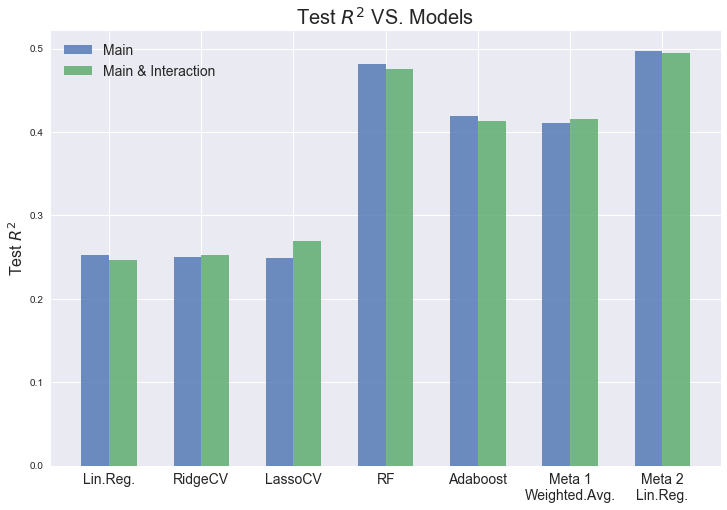

In [44]:
# Visualize the Test R^2 scores of all models
model_names = ['Lin.Reg.', 'RidgeCV', 'LassoCV', 'RF', 'Adaboost', 'Meta 1\nWeighted.Avg.', 'Meta 2\nLin.Reg.']
acc_test_main = [0.25215, 0.25052, 0.24915, 0.48157, 0.41946, 0.41066, 0.49653]
acc_test_int = [0.24658, 0.25243, 0.26894, 0.47592, 0.41286, 0.41578, 0.49444]

width = 0.3
plt.figure(figsize=(12, 8))
plt.bar(np.arange(len(model_names)), acc_test_main, width, alpha=0.8, label='Main')
plt.bar(np.arange(len(model_names))+width, acc_test_int, width, alpha=0.8, label='Main & Interaction')
plt.xticks(np.arange(len(model_names))+0.5*width, model_names, fontsize=14)
plt.title('Test $R^2$ VS. Models ', fontsize=20)
plt.ylabel('Test $R^2$', fontsize=16)
plt.legend(fontsize=14)
plt.show()